# Выбор локации для скважины

Вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
import matplotlib
import seaborn
print("matplotlib version:", matplotlib.__version__)
print("seaborn version:", seaborn.__version__)

matplotlib version: 3.9.4
seaborn version: 0.13.2


In [2]:
!pip install shap -q
!pip -q install phik
!pip install scikit-learn==1.1.3 -q

In [3]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import math
import numpy as np
import time
import phik
import shap
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import  (
    f1_score, 
    roc_auc_score, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    make_scorer,
    mean_squared_error,
    classification_report)
from phik import phik_matrix, report
from phik.report import plot_correlation_matrix
from sklearn.dummy import DummyClassifier, DummyRegressor
from scipy import stats as st

## Загрузка и подготовка данных

In [4]:
try:
    geo_data_0= pd.read_csv(r'C:\Users\dinos\Downloads\geo_data_0.csv', sep=',')
    geo_data_1= pd.read_csv(r'C:\Users\dinos\Downloads\geo_data_1.csv', sep=',')
    geo_data_2= pd.read_csv(r'C:\Users\dinos\Downloads\geo_data_2.csv', sep=',')
    
except:
    geo_data_0= pd.read_csv('/datasets/geo_data_0.csv', sep=',')
    geo_data_1= pd.read_csv('/datasets/geo_data_1.csv', sep=',')
    geo_data_2= pd.read_csv('/datasets/geo_data_2.csv', sep=',')

pd.set_option('display.max_columns', None)

In [5]:
def info(df):
    display(df.head(5))
    display(df.info()) 
    print(f'Количество дубликатов: {df.duplicated().sum()}')
    print(f'Количество пропусков: {df.isna().sum()}')

In [6]:
info(geo_data_0)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Количество дубликатов: 0
Количество пропусков: id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


In [7]:
info(geo_data_1)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Количество дубликатов: 0
Количество пропусков: id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


In [8]:
info(geo_data_2)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Количество дубликатов: 0
Количество пропусков: id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


In [9]:
geo_data_0['id'].value_counts().head(12)

id
fiKDv    2
QcMuo    2
AGS9W    2
Tdehs    2
74z30    2
A5aEY    2
bsk9y    2
TtcGQ    2
HZww2    2
bxg6G    2
iAaqy    1
PQ2MT    1
Name: count, dtype: int64

In [10]:
geo_data_0[geo_data_0['id'] == 'AGS9W']

,id,f0,f1,f2,product
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453


Имеються дубликаты id скважин, удалим повторяющийся

In [11]:
geo_data_0 = geo_data_0.drop_duplicates(subset=['id'], keep=False)
geo_data_0['id'].value_counts().head()

id
txEyH    1
0smZR    1
2PhTu    1
l3icy    1
eIjPq    1
Name: count, dtype: int64

In [12]:
geo_data_1['id'].value_counts().head(10)

id
wt4Uk    2
LHZR0    2
5ltQ6    2
bfPNe    2
kBEdx    1
lAVJZ    1
ENYw9    1
gMInh    1
uPzFJ    1
w75gp    1
Name: count, dtype: int64

In [13]:
geo_data_1 = geo_data_1.drop_duplicates(subset=['id'], keep=False)
geo_data_1['id'].value_counts().head()

id
kBEdx    1
MPu5S    1
9Fdmw    1
ENYw9    1
gMInh    1
Name: count, dtype: int64

In [14]:
geo_data_2['id'].value_counts().head(10)

id
VF7Jo    2
KUPhW    2
xCHr8    2
Vcm5J    2
fwXo0    1
B9hou    1
gtl32    1
V5b65    1
rpqpj    1
Gibob    1
Name: count, dtype: int64

In [15]:
geo_data_2 = geo_data_2.drop_duplicates(subset=['id'], keep=False)
geo_data_2['id'].value_counts().head()

id
fwXo0    1
UhPOG    1
qIzlN    1
2x2Ru    1
gtl32    1
Name: count, dtype: int64

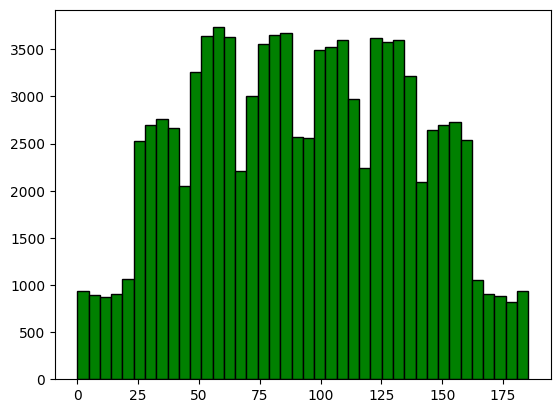

In [16]:
plt.hist(geo_data_0['product'], color = 'green', edgecolor = 'black', bins = 40);

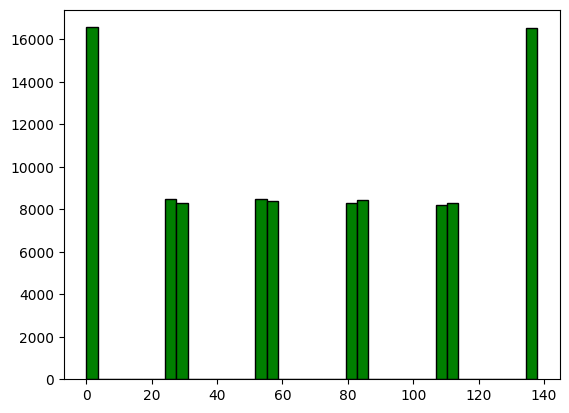

In [17]:
plt.hist(geo_data_1['product'], color = 'green', edgecolor = 'black', bins = 40);

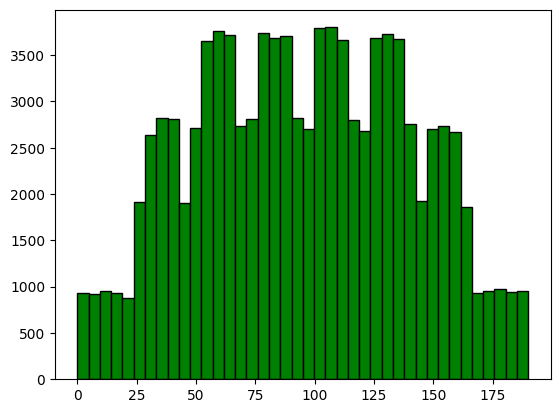

In [18]:
plt.hist(geo_data_2['product'], color = 'green', edgecolor = 'black', bins = 40);

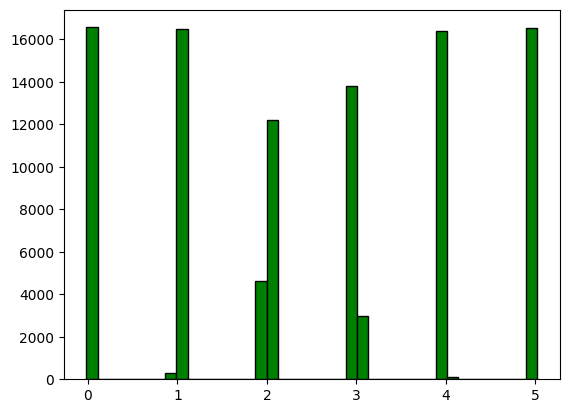

In [19]:
plt.hist(geo_data_1['f2'], color = 'green', edgecolor = 'black', bins = 40);

Во втором регионе странное распределение мест бурение и кол-во запасов в скважине

In [22]:
geo_data_0

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764


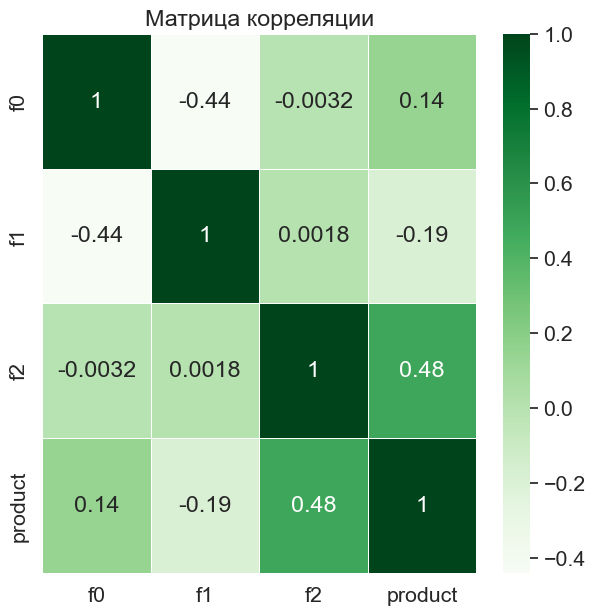

In [28]:
corr_matrix = geo_data_0.drop(['id'], axis=1)
corr_matrix = corr_matrix.corr()
sns.set(font_scale=1.4)
plt.figure(figsize=(7, 7))
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='Greens')
plt.title('Матрица корреляции')
plt.show()

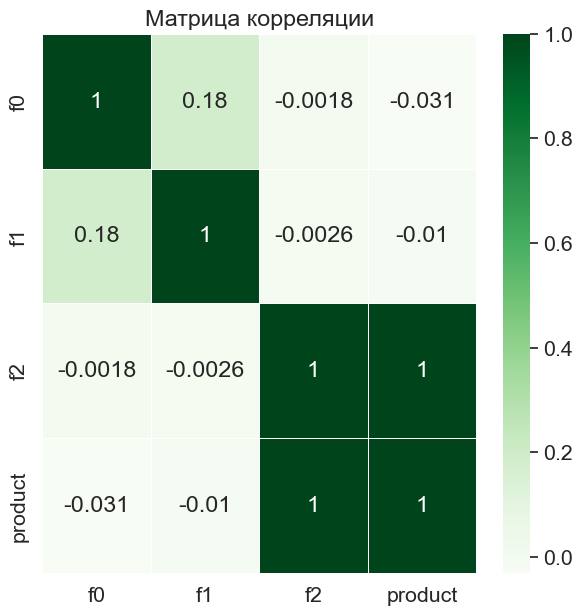

In [30]:
corr_matrix = geo_data_1.drop(['id'], axis=1)
corr_matrix = corr_matrix.corr()
sns.set(font_scale=1.4)
plt.figure(figsize=(7, 7))
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='Greens')
plt.title('Матрица корреляции')
plt.show()

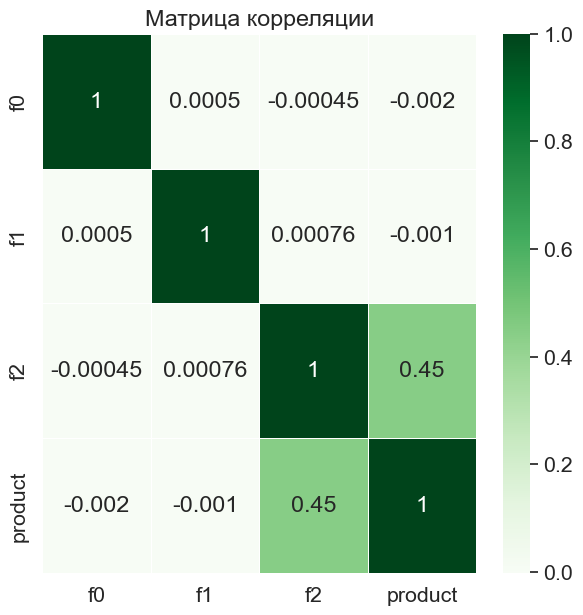

In [31]:
corr_matrix = geo_data_2.drop(['id'], axis=1)
corr_matrix = corr_matrix.corr()
sns.set(font_scale=1.4)
plt.figure(figsize=(7, 7))
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='Greens')
plt.title('Матрица корреляции')
plt.show()

В втором регионе наблюдается очень сильная прямая корреляция между признаком f1 и переменной product, приближающаяся к 1.

## Обучение и проверка модели

удалим колонку с id, т.к. она не несет для нас смысловой нагрузки и в дальнейшем она может вызвать ошибки при обучении

In [34]:
datasets = [geo_data_0, geo_data_1, geo_data_2]

In [35]:
y_valid_list = []
y_pred_list = []

# Обработка данных и обучение моделей
for i, data in enumerate(datasets):
    # Удаление колонки 'id'
    data = data.drop(columns=['id'])

    # Разделение данных на признаки и целевую переменную
    X = data.drop(['product'], axis=1)
    y = data['product']

    # Разделение на обучающую и валидационную выборки
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=12345)

    # Создание и обучение модели
    model = Pipeline([
        ('regressor', LinearRegression())
    ])

    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)

    # Сохранение y_valid и y_pred для текущего региона
    y_valid_list.append(y_valid)
    y_pred_list.append(y_pred)

    # Вычисление RMSE
    rmse = mean_squared_error(y_valid, y_pred)**0.5
    print(f'Среднеквадратичное отклонение для региона {i + 1} равно: {rmse:.2f}')

    # Оценка точности модели
    accuracy = model.score(X_valid, y_valid)
    print(f'Точность модели для региона {i + 1} равна: {accuracy:.2%}')


Среднеквадратичное отклонение для региона 1 равно: 37.72
Точность модели для региона 1 равна: 27.67%
Среднеквадратичное отклонение для региона 2 равно: 0.89
Точность модели для региона 2 равна: 99.96%
Среднеквадратичное отклонение для региона 3 равно: 39.98
Точность модели для региона 3 равна: 19.56%


Анализ результатов показывает, что модель, обученная на данных второго региона, демонстрирует более высокую точность и меньшую среднеквадратичную ошибку. Это, вероятно, обусловлено тем, что данные этого региона имеют меньшую дисперсию, что облегчает процесс обучения модели.

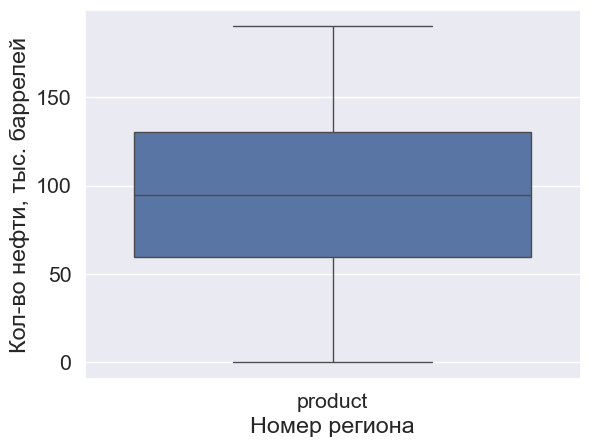

In [36]:
sns.boxplot(data=[data['product'] for data in datasets])
plt.xlabel('Номер региона')
plt.ylabel('Кол-во нефти, тыс. баррелей')
plt.show()

Во 2-ом регионе действительно разброс данных меньше, чем в других

## Подготовка к расчёту прибыли

* Бюджет на разработку скважин в регионе — 10 млрд рублей. (money)
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей. (barrel)
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью. probability

In [37]:
money = 10_000_000_000
barrel = 450_000
probability = 0.025
top_200 = 200
money_one = money/top_200
money_one

50000000.0

Поскольку нам необходимо разработать 200 скважин в регионе, мы можем рассчитать бюджет на одну скважину, который составляет 50 млн. рублей. Следовательно, скважины, которые подходят для разработки, должны иметь запасы нефти, стоимость которых превышает этот порог в 50 млн. руб.

In [38]:
for i, data in enumerate(datasets, 1):
    print(f'Средний объем нефти в {i} регионе: {data["product"].mean()}')

Средний объем нефти в 1 регионе: 92.49916597893444
Средний объем нефти в 2 регионе: 68.82414772665173
Средний объем нефти в 3 регионе: 94.99876686768079


In [39]:
min_barrel = money_one/barrel
min_barrel

111.11111111111111

Из проведенного анализа видно, что минимально необходимый объем нефти для окупаемости скважины составляет 111 тысяч баррелей. Средний уровень добычи нефти в рассматриваемых регионах ниже этого порога, что делает разработку нерентабельной.

Ранее была представлена диаграмма разброса, на которой был продемонстрирован диапазон объемов добычи нефти в регионах. Поэтому нельзя однозначно утверждать, что разработка 200 скважин приведет к убыткам во всех случаях — это зависит от конкретных условий каждого региона.

Расчет прибыли региона будет производиться по следующей формуле:

прибыль = (количество тыс. баррелей, добытых в регионе) * (стоимость 1 тыс. баррелей) - (бюджет, затраченный на разработку скважин в регионе).

In [40]:
def profit(target_valid, predictions_valid, top_200):
    predictions = pd.Series(predictions_valid)
    # Получаем индексы топ-200 предсказаний
    top_indices = predictions.nlargest(top_200).index
    
    # Используем iloc для выбора целевых значений по индексам
    best_points = target_valid.iloc[top_indices].sum()

    return (best_points * barrel - money) / 1000000

## Расчёт прибыли и рисков 

Отсортируем предсказания по убыванию, таким образом чтобы первые 200 значений были самыми большими из предсказаний.
Посчитаем суммарное кол-во нефти в них и прибыль которую они могу принести.

In [41]:
for i, prediction in enumerate(y_pred_list):
    sum_bar = prediction[:200].sum()
    print(f'Объем нефти в {i+1} регионе равен {sum_bar:.0f} тыс. баррелей')

Объем нефти в 1 регионе равен 17833 тыс. баррелей
Объем нефти в 2 регионе равен 14391 тыс. баррелей
Объем нефти в 3 регионе равен 19321 тыс. баррелей


In [42]:
profit_0 = profit(y_valid_list[0], y_pred_list[0], top_200)
profit_1 = profit(y_valid_list[1], y_pred_list[1], top_200)
profit_2 = profit(y_valid_list[2], y_pred_list[2], top_200)
print('Прибыль с 1 региона равна %.2f' % profit_0, 'млн. руб.')
print('Прибыль с 2 региона равна %.2f' % profit_1, 'млн. руб.')
print('Прибыль с 3 региона равна %.2f' % profit_2, 'млн. руб.')

Прибыль с 1 региона равна 3136.03 млн. руб.
Прибыль с 2 региона равна 2415.09 млн. руб.
Прибыль с 3 региона равна 2465.95 млн. руб.


In [43]:
def bootstrap1000(target, predict, n):
    state = np.random.RandomState(12345)
    profits = []
    count = 0

    for i in range(1000):
        target_subsample = target.reset_index(drop= True).sample(n, random_state=state, replace=True)
        probs_subsample = predict[target_subsample.index]
        #сортируем список по запасам нефти
        profits.append(profit(target_subsample,
                              probs_subsample, top_200))#заполняем прибыть
    profits = pd.Series(profits)
    
    count = profits[profits<0].count()/1000

    lower = profits.quantile(0.025)
    upper = profits.quantile(.975)

    print('Средняя прибыль в регионе равна: %.2f' % (profits.mean()), 'мл. руб.')
    print('95% доверительный интервал лежит в диапазоне: {:.2f}'.format(lower),
          '- {:.2f}'.format(upper))
    print('Вероятность убытка равна: {:.2%}'.format(count))

In [44]:
print('Для первого региона:')
bootstrap1000(y_valid_list[0], y_pred_list[0], 500)

Для первого региона:
Средняя прибыль в регионе равна: 431.54 мл. руб.
95% доверительный интервал лежит в диапазоне: -80.92 - 941.04
Вероятность убытка равна: 5.50%


In [45]:
print('Для вторго региона:')
bootstrap1000(y_valid_list[1], y_pred_list[1], 500)

Для вторго региона:
Средняя прибыль в регионе равна: 477.95 мл. руб.
95% доверительный интервал лежит в диапазоне: 51.74 - 897.94
Вероятность убытка равна: 2.00%


In [46]:
print('Для третьего региона:')
bootstrap1000(y_valid_list[2], y_pred_list[2], 500)

Для третьего региона:
Средняя прибыль в регионе равна: 322.15 мл. руб.
95% доверительный интервал лежит в диапазоне: -173.46 - 843.53
Вероятность убытка равна: 12.30%


## Вывод

Мы проанализировали данные по запасам нефти в трех регионах, каждый из которых содержал информацию о 10 тысячах скважин. Для оценки перспективности разработки регионов мы обучили модель и выполнили прогнозы с использованием линейной регрессии, а также применили метод bootstrap, разделив каждое предсказанное значение прибыли по регионам на 1000 выборок.

На основе полученных данных мы рассчитали доверительный интервал прибыли с уровнем 95%, ограничив вероятность убытков до менее чем 2,5%. Эти результаты позволили нам выбрать наиболее перспективный регион для разработки 200 скважин.

Подводя итог могу сказать, что наимее потенциально убыточно было бы вложить бюджет в развитие добычи во 2 регионе, т.к там самая низкая вероятность убытка, при этом самая высокая средняя прибыль.